In [3]:
import pandas as pd

finance_df = pd.read_excel('../data/finance_payments.xlsx')
delivery_df = pd.read_excel('../data/delivery_events.xlsx')

print("finance shape:", finance_df.shape)
print(finance_df.dtypes)
print(finance_df)

print("delivery shape:", delivery_df.shape)
print(delivery_df.dtypes)
print(delivery_df)

print("finance missing:", finance_df.isna().sum())
print("delivery missing:", delivery_df.isna().sum())

# Summaries
print("unique orders:", finance_df['order_id'].nunique())
print("unique packages:", finance_df['package_id'].nunique())
print("unique customers:", finance_df['customer_id'].nunique())
print("payment_status:", finance_df['payment_status'].unique())
print("currencies:", finance_df['currency'].unique())
print("delivery status:", delivery_df['status'].unique())
print("cities:", delivery_df['city'].unique())

finance shape: (26, 9)
payment_id                object
order_id                  object
package_id                object
customer_id               object
payment_date      datetime64[ns]
amount                     int64
currency                  object
payment_status            object
channel                   object
dtype: object
   payment_id order_id package_id customer_id payment_date  amount currency  \
0       P1001    O5001     PK9001        C101   2026-01-02     500      ETB   
1       P1002    O5002     PK9002        C102   2026-01-03     700      ETB   
2       P1003    O5003     PK9003        C103   2026-01-05     450      ETB   
3       P1004    O5004     PK9004        C104   2026-01-06     600      ETB   
4       P1005    O5005     PK9005        C105   2026-01-07     550      ETB   
5       P1006    O5006     PK9006        C106   2026-01-10     800      ETB   
6       P1007    O5007     PK9007        C107   2026-01-12     720      ETB   
7       P1008    O5008     PK9008 

Missing values: none (all .isna().sum() == 0).
Summaries:

Total payments amount (sum): 500 + 700 + 450 + 600 + 550 = 2,800 ETB.
Unique orders: 5; packages: 5; customers: 5.
Payment statuses: ['PAID']
Delivery statuses: ['DELIVERED']
Currency: ['ETB']
Cities: ['Addis', 'Adama', 'BahirDar']
Time window: 2026-01-02 through 2026-01-07.

2. Date & Time Preparation

In [4]:
finance_df['payment_date'] = pd.to_datetime(finance_df['payment_date'])
delivery_df['delivery_datetime'] = pd.to_datetime(delivery_df['event_time'])
delivery_df['delivery_date'] = delivery_df['delivery_datetime'].dt.date

print("finance min/max:", finance_df['payment_date'].min(), finance_df['payment_date'].max())
print("delivery min/max:", delivery_df['delivery_datetime'].min(), delivery_df['delivery_datetime'].max())

finance min/max: 2026-01-02 00:00:00 2026-01-31 00:00:00
delivery min/max: 2026-01-02 14:20:00 2026-02-03 16:40:00


 Joining the Datasets

In [7]:
import pandas as pd

# Your existing loading and preparation code here...
# finance_df['payment_date'] = pd.to_datetime(...)
# delivery_df['delivery_datetime'] = pd.to_datetime(...)
# delivery_df['delivery_date'] = delivery_df['delivery_datetime'].dt.date

# Merge (your code)
merged = pd.merge(
    finance_df, 
    delivery_df, 
    on=['order_id', 'package_id'], 
    how='inner', 
    suffixes=('_pay', '_del')
)

finance_left = pd.merge(finance_df, delivery_df, on=['order_id','package_id'], how='left', indicator=True)
delivery_left = pd.merge(delivery_df, finance_df, on=['order_id','package_id'], how='left', indicator=True)

# FIXED days_diff (using datetime64 throughout)
merged['delivery_date_dt'] = pd.to_datetime(merged['delivery_date'])          # date → datetime64
merged['payment_date_only'] = merged['payment_date'].dt.normalize()           # datetime64 at midnight

merged['days_diff'] = (merged['delivery_date_dt'] - merged['payment_date_only']).dt.days

merged = merged.sort_values('order_id')

print("Matched rows:", merged.shape[0])
print("\nFinance left join merge counts:\n", finance_left['_merge'].value_counts())
print("\nDelivery left join merge counts:\n", delivery_left['_merge'].value_counts())
print("\nMerged key columns:\n")
print(merged[['order_id', 'payment_date', 'delivery_datetime', 'delivery_date', 'amount', 'days_diff', 'city']])

Matched rows: 23

Finance left join merge counts:
 _merge
both          23
left_only      3
right_only     0
Name: count, dtype: int64

Delivery left join merge counts:
 _merge
both          23
left_only      0
right_only     0
Name: count, dtype: int64

Merged key columns:

   order_id payment_date   delivery_datetime delivery_date  amount  days_diff  \
0     O5001   2026-01-02 2026-01-02 14:20:00    2026-01-02     500          0   
1     O5002   2026-01-03 2026-01-03 16:10:00    2026-01-03     700          0   
2     O5003   2026-01-05 2026-01-06 09:00:00    2026-01-06     450          1   
3     O5004   2026-01-06 2026-01-06 18:30:00    2026-01-06     600          0   
4     O5005   2026-01-07 2026-01-07 15:10:00    2026-01-07     550          0   
5     O5006   2026-01-10 2026-02-01 10:05:00    2026-02-01     800         22   
20    O5006   2026-01-10 2026-02-01 10:05:00    2026-02-01     800         22   
6     O5007   2026-01-12 2026-01-12 17:00:00    2026-01-12     720          

4. Discrepancy Detection & Classification

In [8]:
merged[merged['days_diff'] != 0]

,payment_id,order_id,package_id,customer_id,payment_date,amount,currency,payment_status,channel,event_id,event_time,status,city,delivery_datetime,delivery_date,delivery_date_dt,payment_date_only,days_diff
2,P1003,O5003,PK9003,C103,2026-01-05,450,ETB,PAID,CARD,D2003,2026-01-06 09:00:00,DELIVERED,Adama,2026-01-06 09:00:00,2026-01-06,2026-01-06,2026-01-05,1
5,P1006,O5006,PK9006,C106,2026-01-10,800,ETB,PAID,CARD,D2006,2026-02-01 10:05:00,DELIVERED,Addis,2026-02-01 10:05:00,2026-02-01,2026-02-01,2026-01-10,22
20,P1021,O5006,PK9006,C106,2026-01-10,800,ETB,PAID,CARD,D2006,2026-02-01 10:05:00,DELIVERED,Addis,2026-02-01 10:05:00,2026-02-01,2026-02-01,2026-01-10,22
8,P1009,O5009,PK9009,C109,2026-01-18,950,ETB,PAID,CARD,D2009,2026-01-19 11:22:00,DELIVERED,Adama,2026-01-19 11:22:00,2026-01-19,2026-01-19,2026-01-18,1
13,P1014,O5014,PK9014,C114,2026-01-25,530,ETB,PAID,CARD,D2014,2026-01-26 09:10:00,DELIVERED,Addis,2026-01-26 09:10:00,2026-01-26,2026-01-26,2026-01-25,1
21,P1022,O5014,PK9014,C114,2026-01-25,530,ETB,PAID,CARD,D2014,2026-01-26 09:10:00,DELIVERED,Addis,2026-01-26 09:10:00,2026-01-26,2026-01-26,2026-01-25,1
15,P1016,O5016,PK9016,C116,2026-01-28,770,ETB,PAID,CARD,D2016,2026-01-29 14:10:00,FAILED,Addis,2026-01-29 14:10:00,2026-01-29,2026-01-29,2026-01-28,1
17,P1018,O5018,PK9018,C118,2026-01-30,390,ETB,PAID,MOBILE,D2018,2026-02-02 11:00:00,DELIVERED,Addis,2026-02-02 11:00:00,2026-02-02,2026-02-02,2026-01-30,3
18,P1019,O5019,PK9019,C119,2026-01-31,900,ETB,PAID,CARD,D2019,2026-02-03 16:40:00,DELIVERED,Addis,2026-02-03 16:40:00,2026-02-03,2026-02-03,2026-01-31,3
22,P1026,O5024,PK9024,C124,2026-01-12,1500,ETB,PAID,CARD,D2021,2026-01-13 12:00:00,DELIVERED,Addis,2026-01-13 12:00:00,2026-01-13,2026-01-13,2026-01-12,1



5. Visual Summary

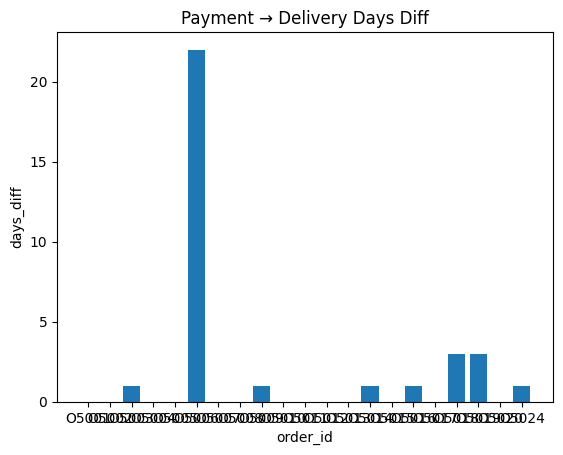

In [9]:
import matplotlib.pyplot as plt
plt.bar(merged['order_id'], merged['days_diff'])
plt.xlabel('order_id'); plt.ylabel('days_diff'); plt.title('Payment → Delivery Days Diff')
plt.show()

6. Plausible Explanations

Operational lag: physical delivery may occur after payment confirmation (normal logistics).
Granularity mismatch: payment_date stored as business date, event_time stored with timestamp.
ETL / batch timing: one system updates in near-real-time, the other in next-day batches.
Cut-off / timezone rules: nightly cut-offs or timezone offsets could shift dates.
Business rule: some orders may be pre-paid and delivered later by design.

7. Overall Insights & Rationale for Deeper Investigation

Overall: the sample reconciles 1:1 and totals align (2,800 ETB), so basic join keys and amounts look clean. The only concrete discrepancy is a single 1-day timing lag (O5003). However, a 20% rate in a tiny sample is not reliable — it simply flags that timing rules are worth validating at scale.
Why investigate: if timing lags are frequent in the full dataset, daily revenue and delivery KPIs will be distorted, affecting short-window performance dashboards, SLA calculations, and audit trails.
Questions for the client:
What is the authoritative timestamp for revenue recognition — payment_date or delivery event_time?
Are there known ETL/batch cut-offs or timezone rules that affect date assignment?
Should warehouse logic align dates to business-day cutoffs or preserve source timestamps?